In [566]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import sklearn.metrics as met
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')
%matplotlib inline

In [567]:
from random import randint, seed
seed(42)

## Преобразование тренировочных данных

In [568]:
data = pd.read_csv('train.csv')
print(data.shape)
print(data.dropna().shape) # стало быть нужно заполнять пропуски

(1460, 81)
(0, 81)


In [569]:
data_Id = data['Id']
data_target = data['SalePrice'].copy() # целевая переменная
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [570]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [571]:
data.drop(labels=['Id', 'SalePrice'], inplace=True, axis=1)

In [572]:
# делим данные по типу на строки и  числа
num_data = data.select_dtypes(exclude = 'object')
cat_data = data.select_dtypes(exclude = ['int64', 'float64'])

cat_features, num_features = cat_data.columns, num_data.columns

## Категориальные признаки

In [573]:
print(len(data['GarageCars'][data['GarageCars'] == 0]), 'Гараж не имеет место для машины ==> их нет')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col].fillna('No_Garage', inplace=True)

data['is_Garage'] = (data['GarageCars'] == 0)*1 # Признак есть ли гараж

81 Гараж не имеет место для машины ==> их нет


In [574]:
print(len(data['TotalBsmtSF'][data['TotalBsmtSF'] == 0]), 'Домов не имеют подвала')

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    data[col].fillna('No_Bstm', inplace=True)

data['is_Bsmt'] = (data['TotalBsmtSF'] == 0)*1 # Признак есть ли подвал

37 Домов не имеют подвала


In [575]:
for col in cat_features:
    data[col].fillna('No{}'.format(col), inplace=True)

In [576]:
#imp = SimpleImputer(strategy='most_frequent')
#data[cat_features] = imp.fit_transform(data[cat_features])

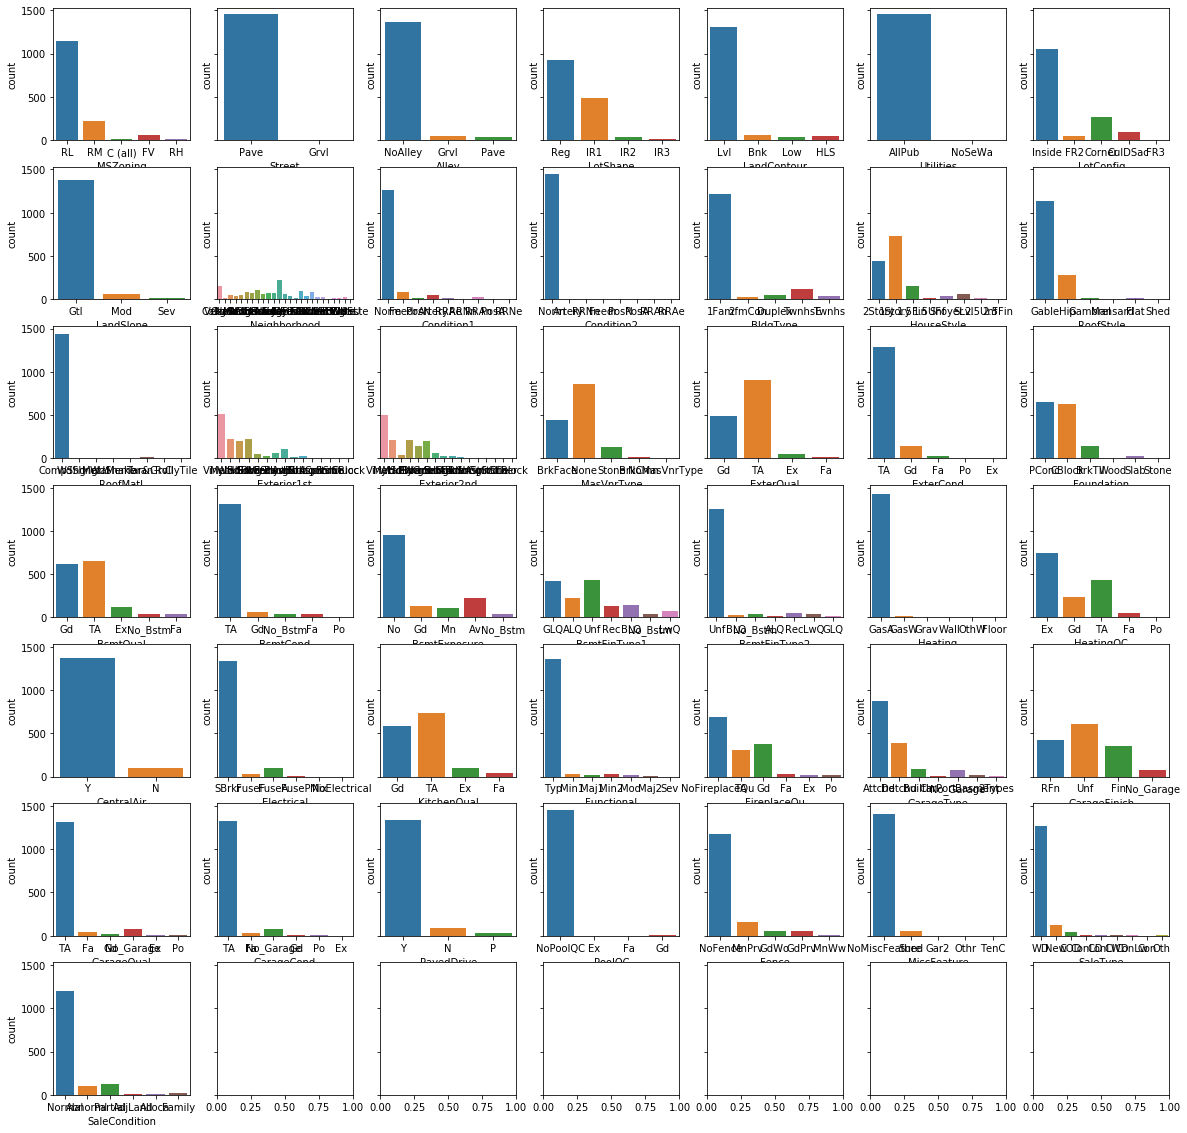

In [577]:
fig, axes = plt.subplots(7, 7, figsize=(20, 20), sharey=True)
for i in range(len(cat_features)):
    sns.countplot(x=cat_features[i], data=data, ax=axes[i // 7, i % 7])

In [578]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for label in cat_features:
    data[label] = encoder.fit_transform(data[label])
    
data[cat_features]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,1,1,3,3,0,4,0,8,2,...,1,2,5,5,2,3,4,1,8,4
1456,3,1,1,3,3,0,4,0,14,2,...,1,3,5,5,2,3,2,1,8,4
1457,3,1,1,3,3,0,4,0,6,2,...,1,2,5,5,2,3,0,3,8,4
1458,3,1,1,3,3,0,4,0,12,2,...,1,3,5,5,2,3,4,1,8,4


## Вещественные признаки :

### MasVnrArea : 

In [579]:
#f,ax = plt.subplots(figsize=(20,2))
#sns.heatmap(num_data.corr().iloc[7:8,:], annot=True, linewidths=.8, fmt= '.1f',ax=ax)

In [580]:
len(data[data.MasVnrArea.values == 0].index)
# больше половины данных - нули, логично 8 недостающих значений ими и заполнить

861

In [581]:
data.MasVnrArea = data.MasVnrArea.fillna(0)

### GarageYrBlt :

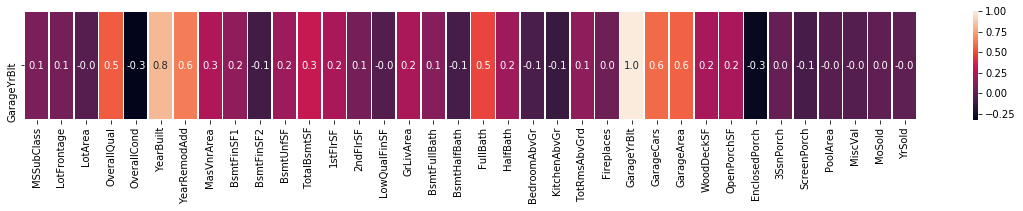

In [582]:
f,ax = plt.subplots(figsize=(20,2))
sns.heatmap(num_data.corr().iloc[24:25,:], annot=True, linewidths=.8, fmt= '.1f',ax=ax)

In [583]:
data["GarageYrBlt"] = data.groupby("YearBuilt")["GarageYrBlt"].transform(
    lambda x: x.fillna(x.median()))
data["GarageYrBlt"] = data["GarageYrBlt"].fillna(data["GarageYrBlt"].median())

### LotFrontage : 

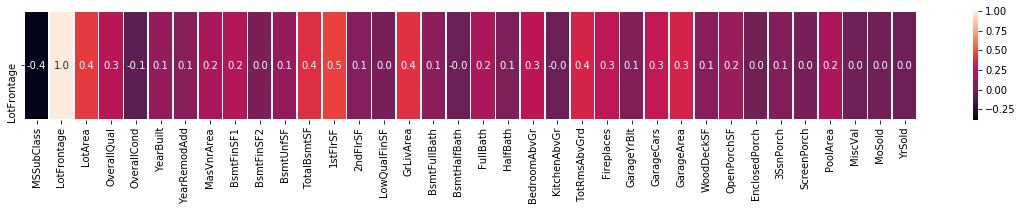

In [584]:
f,ax = plt.subplots(figsize=(20,2))
sns.heatmap(num_data.corr().iloc[1:2,:], annot=True, linewidths=.8, fmt= '.1f',ax=ax)

In [585]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [586]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,is_Garage,is_Bsmt
0,60,3,65.0,8450,1,1,3,3,0,4,...,3,4,1,0,2,2008,8,4,0,0
1,20,3,80.0,9600,1,1,3,3,0,2,...,3,4,1,0,5,2007,8,4,0,0
2,60,3,68.0,11250,1,1,0,3,0,4,...,3,4,1,0,9,2008,8,4,0,0
3,70,3,60.0,9550,1,1,0,3,0,0,...,3,4,1,0,2,2006,8,0,0,0
4,60,3,84.0,14260,1,1,0,3,0,2,...,3,4,1,0,12,2008,8,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,1,3,3,0,4,...,3,4,1,0,8,2007,8,4,0,0
1456,20,3,85.0,13175,1,1,3,3,0,4,...,3,2,1,0,2,2010,8,4,0,0
1457,70,3,66.0,9042,1,1,3,3,0,4,...,3,0,3,2500,5,2010,8,4,0,0
1458,20,3,68.0,9717,1,1,3,3,0,4,...,3,4,1,0,4,2010,8,4,0,0


## Очистка от выбросов : 

In [587]:
#sns.boxplot(data_target)
rubbish_index = data_target[data_target > 500_000].index

data.drop(index=rubbish_index,inplace=True)
data_target.drop(index=rubbish_index,inplace=True)

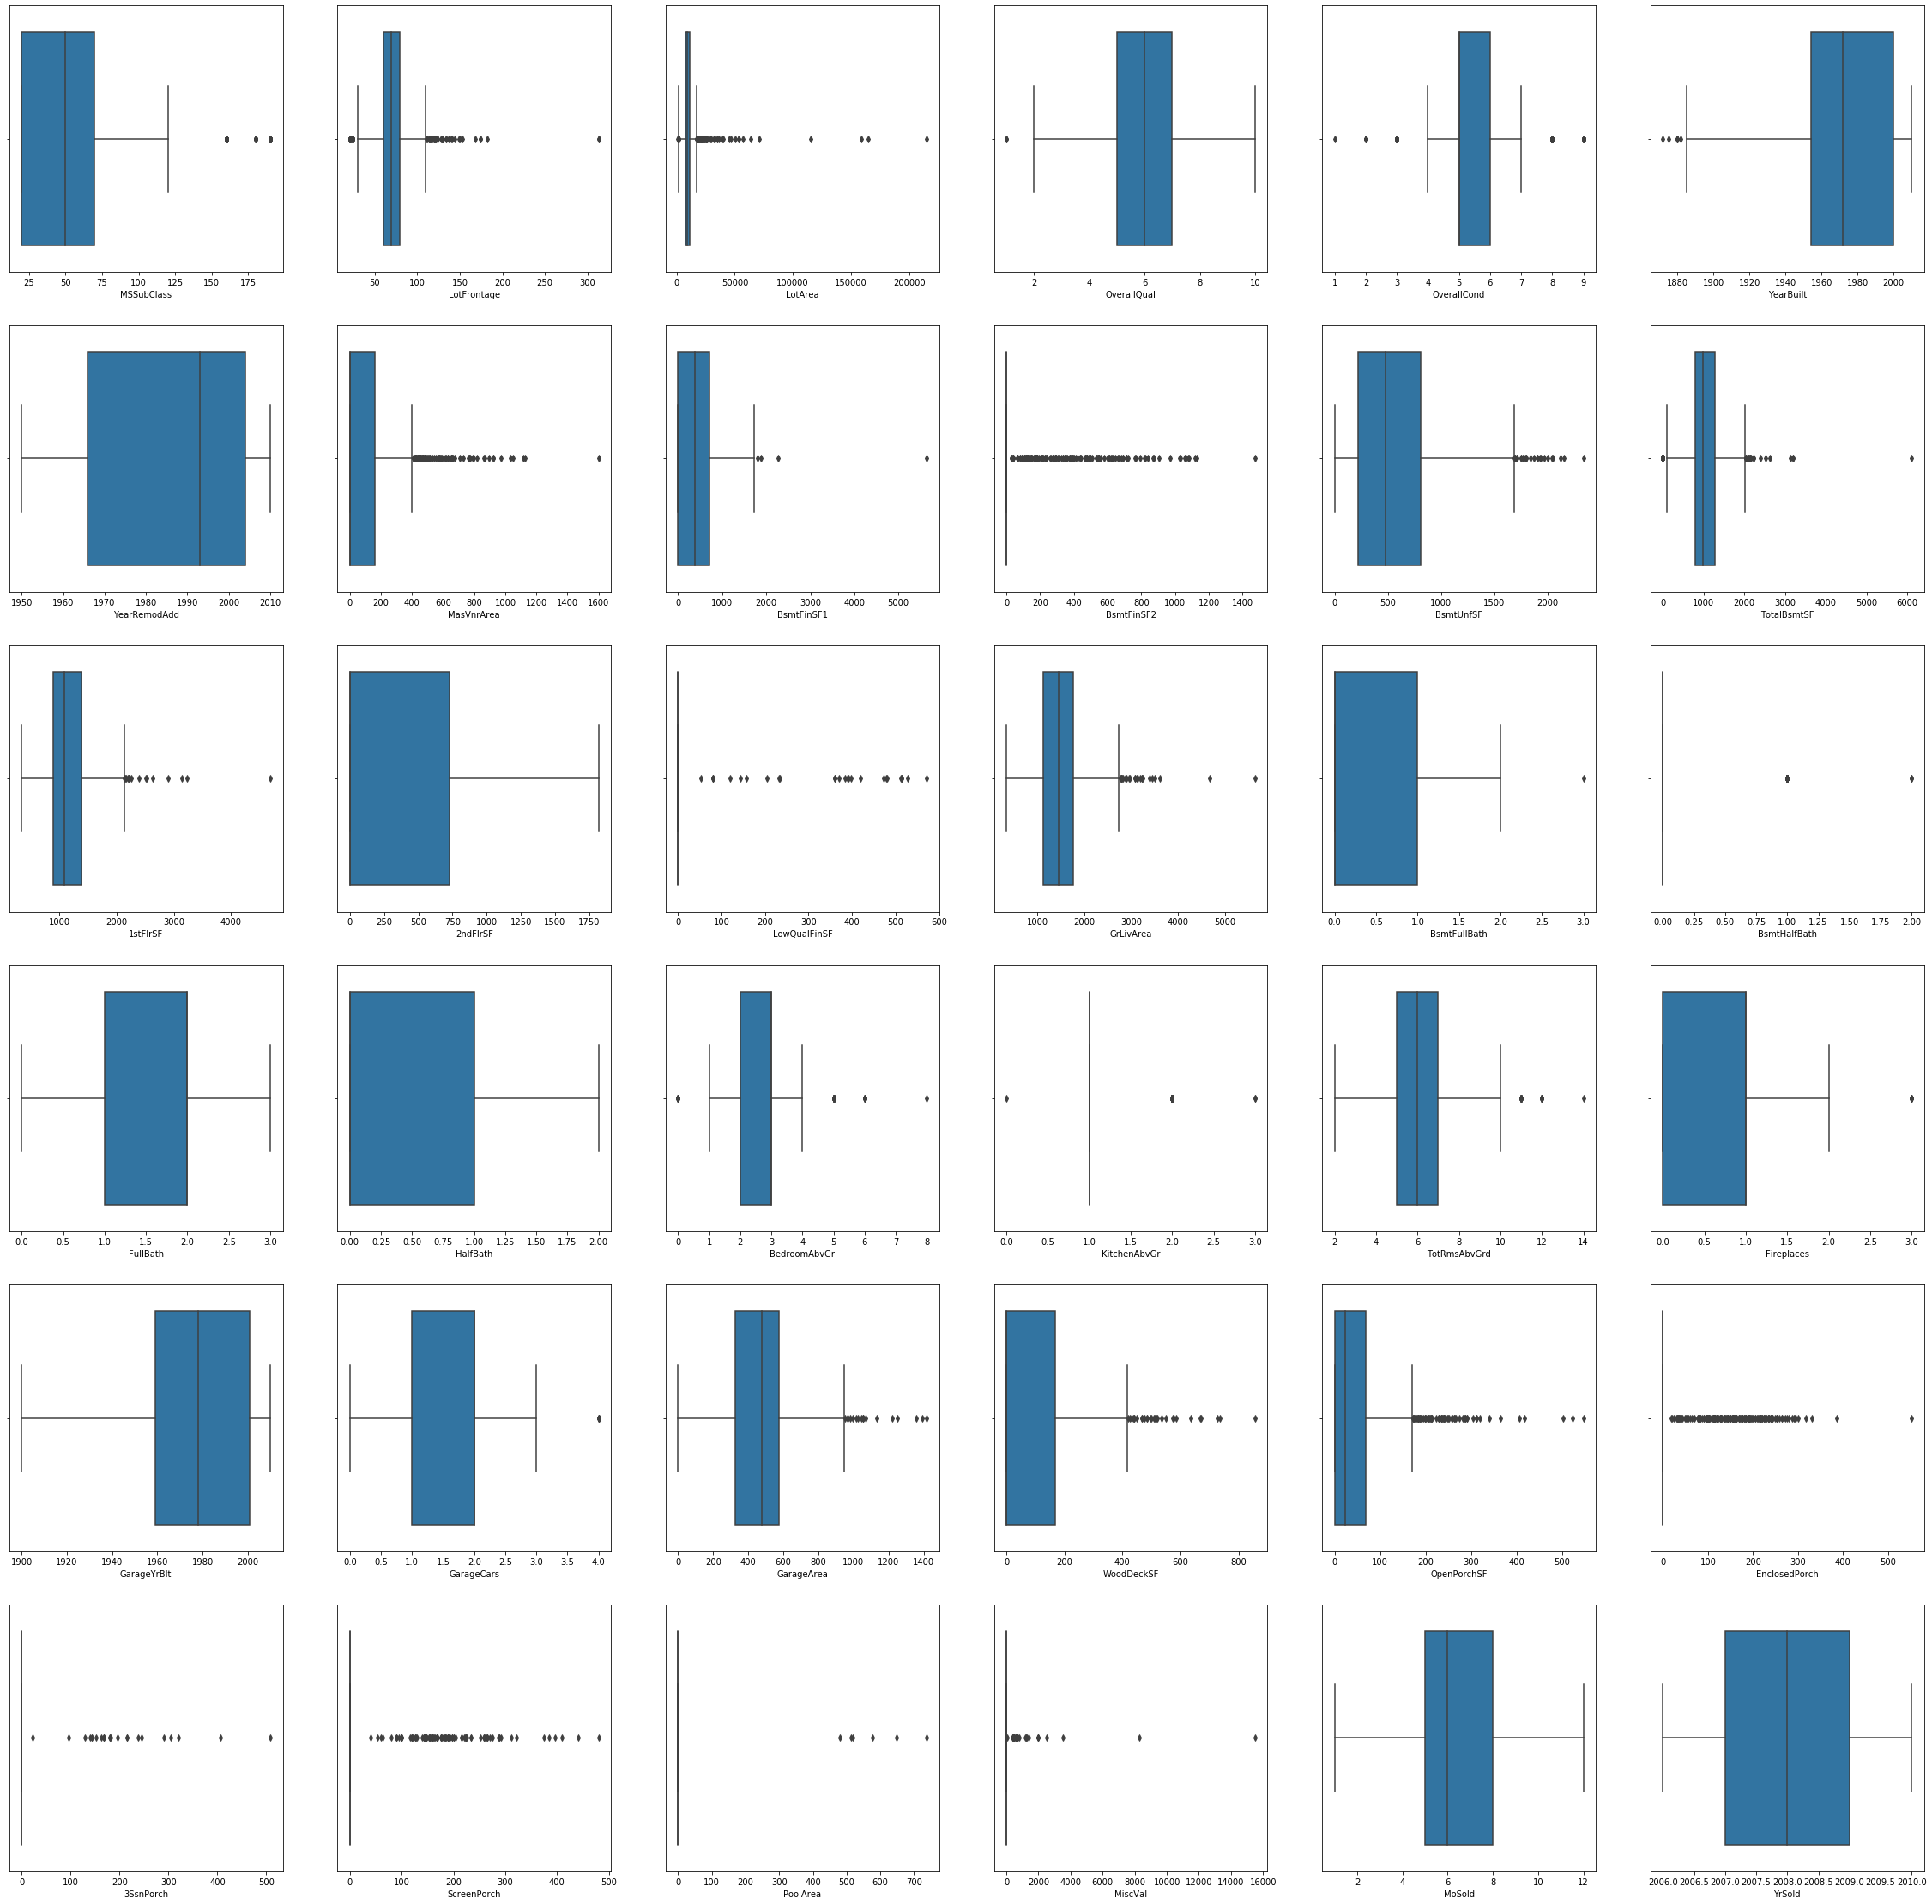

In [588]:
fig, axes = plt.subplots(6, 6, figsize=(40, 40), sharey=True)
for i in range(len(num_features)):
    sns.boxplot(x=num_features[i], data=data, ax=axes[i // 6, i % 6])

Данных слишком мало, чтобы избавляться от выбросов в таком количестве, заменим их максимальным значением 99% выборки

In [589]:
#for col in ['LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
#       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
#       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
#            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']:
#    low, up = np.percentile(data[col].values, [0.3 , 99])
#    
#    bad_index = list(data[data[col].values > up].index)
#    data[col].drop(index=bad_index, inplace=True)
#    data[col].fillna(data[col].max(), inplace=True)

In [590]:
#fig, axes = plt.subplots(6, 6, figsize=(40, 40), sharey=True)
#for i in range(len(num_features)):
#    sns.boxplot(x=num_features[i], data=data, ax=axes[i // 6, i % 6])

## MDS

In [591]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state=42, n_jobs=-2)

In [592]:
%%time
mds_data = mds.fit_transform(data)

Wall time: 2min 10s


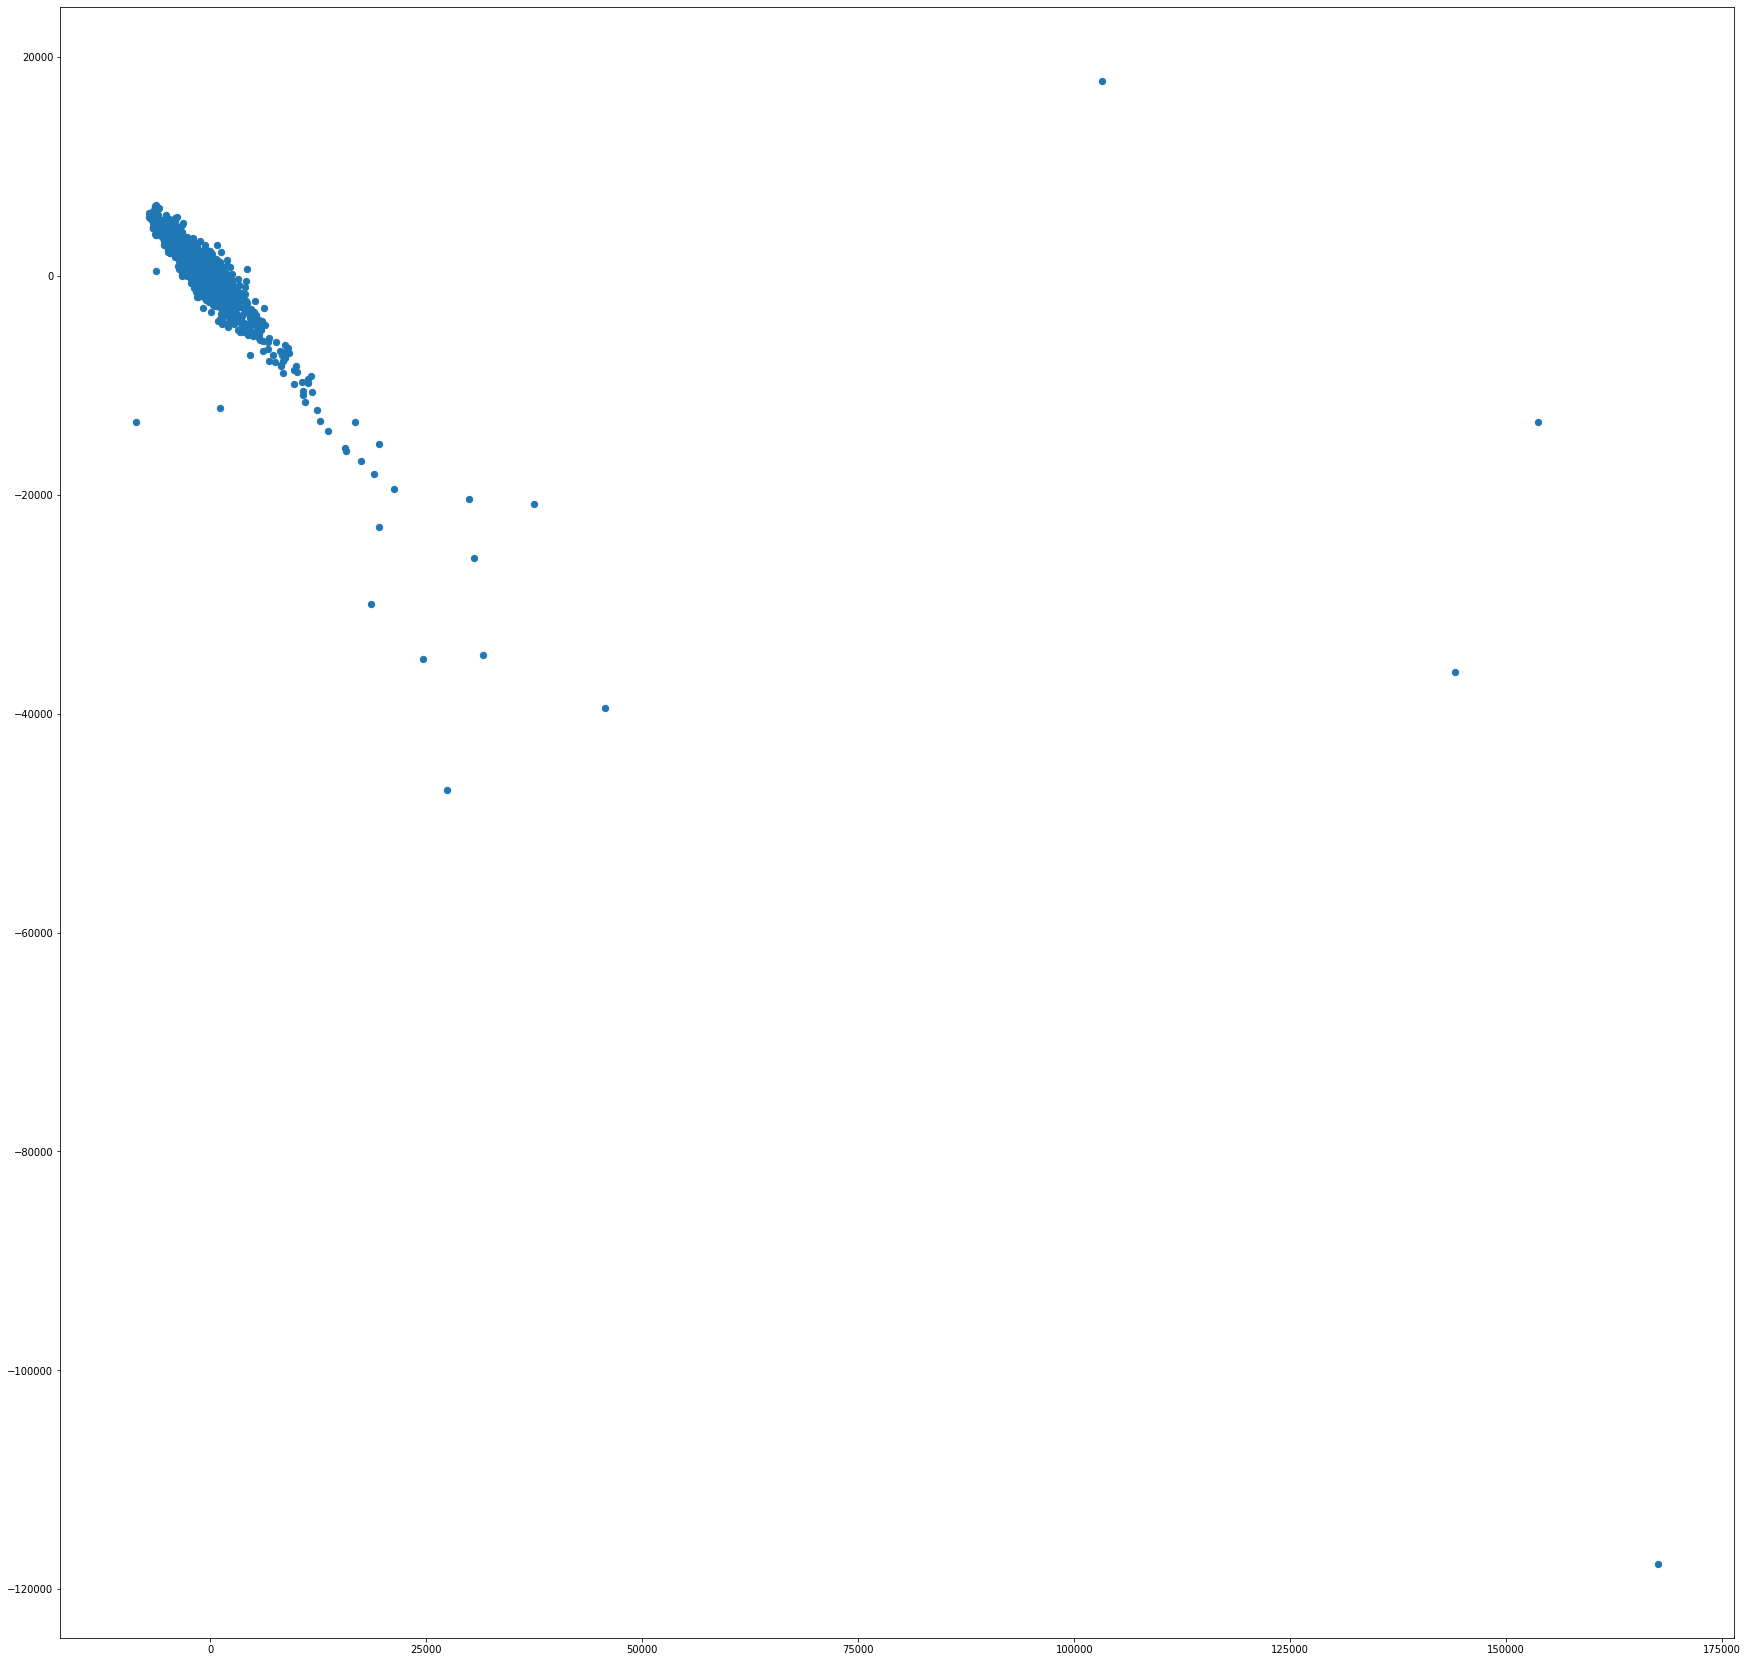

In [593]:
plt.figure(figsize = (30, 30))
plt.scatter(mds_data[:, 0], mds_data[:, 1], s=40)

In [594]:
rubbish_index = []

for i in range(len(mds_data)):
    if (abs(mds_data[:, 1][i]) > 10_000) or (abs(mds_data[:, 0][i]) > 15_000):
        rubbish_index.append(i)
len(rubbish_index)

29

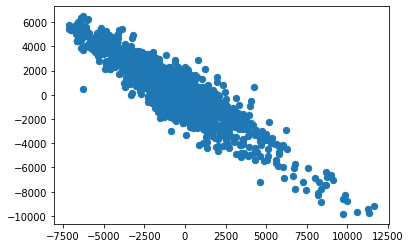

In [595]:
plt.scatter(pd.DataFrame(mds_data).drop(index=rubbish_index).values[:, 0], 
            pd.DataFrame(mds_data).drop(index=rubbish_index).values[:, 1], s=40)

In [596]:
data = data.drop(index=rubbish_index)
data_target = data_target.drop(index=rubbish_index)

In [597]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,is_Garage,is_Bsmt
0,60,3,65.0,8450,1,1,3,3,0,4,...,3,4,1,0,2,2008,8,4,0,0
1,20,3,80.0,9600,1,1,3,3,0,2,...,3,4,1,0,5,2007,8,4,0,0
2,60,3,68.0,11250,1,1,0,3,0,4,...,3,4,1,0,9,2008,8,4,0,0
3,70,3,60.0,9550,1,1,0,3,0,0,...,3,4,1,0,2,2006,8,0,0,0
4,60,3,84.0,14260,1,1,0,3,0,2,...,3,4,1,0,12,2008,8,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,1,3,3,0,4,...,3,4,1,0,8,2007,8,4,0,0
1456,20,3,85.0,13175,1,1,3,3,0,4,...,3,2,1,0,2,2010,8,4,0,0
1457,70,3,66.0,9042,1,1,3,3,0,4,...,3,0,3,2500,5,2010,8,4,0,0
1458,20,3,68.0,9717,1,1,3,3,0,4,...,3,4,1,0,4,2010,8,4,0,0


## Кластеризация T-SNE

In [598]:
%%time
tsne = TSNE(n_components=2, random_state=42)

tsne_data = tsne.fit_transform(data)

Wall time: 21.2 s


In [599]:
#plt.figure(figsize = (30, 30))
#plt.scatter(tsne_data[:, 0][new_class == 0], tsne_data[:, 1][new_class == 0], s=15, c='blue')
#plt.scatter(tsne_data[:, 0][new_class == 1], tsne_data[:, 1][new_class == 1], s=15, c='olive')
#plt.scatter(tsne_data[:, 0][new_class == 2], tsne_data[:, 1][new_class == 2], s=15, c='green')
#plt.scatter(tsne_data[:, 0][new_class == 3], tsne_data[:, 1][new_class == 3], s=15, c='red')

In [600]:
for i in range(1, 5):
    clust = AgglomerativeClustering(n_clusters=3*i)
    new_class = clust.fit_predict(tsne_data)
    data['class_{}'.format(3*i)] = new_class

In [601]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MoSold,YrSold,SaleType,SaleCondition,is_Garage,is_Bsmt,class_3,class_6,class_9,class_12
0,60,3,65.0,8450,1,1,3,3,0,4,...,2,2008,8,4,0,0,0,3,8,8
1,20,3,80.0,9600,1,1,3,3,0,2,...,5,2007,8,4,0,0,0,1,4,4
2,60,3,68.0,11250,1,1,0,3,0,4,...,9,2008,8,4,0,0,1,5,5,11
3,70,3,60.0,9550,1,1,0,3,0,0,...,2,2006,8,0,0,0,0,3,2,5
4,60,3,84.0,14260,1,1,0,3,0,2,...,12,2008,8,4,0,0,1,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,1,3,3,0,4,...,8,2007,8,4,0,0,0,3,8,8
1456,20,3,85.0,13175,1,1,3,3,0,4,...,2,2010,8,4,0,0,1,0,3,2
1457,70,3,66.0,9042,1,1,3,3,0,4,...,5,2010,8,4,0,0,0,4,1,1
1458,20,3,68.0,9717,1,1,3,3,0,4,...,4,2010,8,4,0,0,0,1,4,4


# EDA

In [602]:
#for col in data.columns:    
#    print(len(np.unique(data[col])))

In [603]:
#float_features = data.select_dtypes(include='float').columns

In [604]:
#sns.pairplot(data[float_features])

In [605]:
#sns.pairplot(data.iloc[:, :2])

# Выбор модели

## Отбор признаков

In [606]:
# Прежде чем использовать ансамбли деревьев, было бы неплохо узнать наиболее информативные признаки
bestfeatures = SelectKBest(score_func=chi2, k=40)
fit = bestfeatures.fit(data,data_target)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
#print(featureScores.nlargest(40,'Score'))

In [607]:
model = ExtraTreesRegressor(criterion='mae')
model.fit(data,data_target)

feat_importances = pd.Series(model.feature_importances_, index=data.columns)
#feat_importances.nlargest(60)

In [608]:
#%%time
#xgb_reg = XGBRegressor(learning_rate=0.01, n_estimators=1000, max_depth = 4, random_state=42, subsample=0.9)
#error = []
#
#for i in range(10):
#    for j in range(5):
#        features_tree=set(list(feat_importances.nlargest(46+2*i).index)) # top 66 features by tree classifier
#        features_chi=set(list(featureScores.Specs[:10+5*j]))# top 40 features by chi square test
#        union_fe=features_chi.union(features_tree)
#        union_fe=list(union_fe)
#    
#        train_xgb_data, test_xgb_data, train_xgb_labels, test_xgb_labels = train_test_split(data[union_fe], 
#                                         data_target,  shuffle=True, test_size=0.2 , random_state = 42)
#        
#        xgb_reg.fit(X=train_xgb_data, y=train_xgb_labels)
#        prediction_xgb = xgb_reg.predict(test_xgb_data)
#        error.append(mae(test_xgb_labels, prediction_xgb))
#        print(i, j, mae(test_xgb_labels, prediction_xgb))

In [609]:
# Наиболее корелирующие с целевой переменной признаки будем учитывать при отборе признаков
corr =[]

for i in range(data.shape[1]):
    corr.append(np.corrcoef(data_target, data.values[:, i])[0][1])

In [610]:
best_corr = list(pd.Series(corr, index=data.columns).nlargest(20).index)

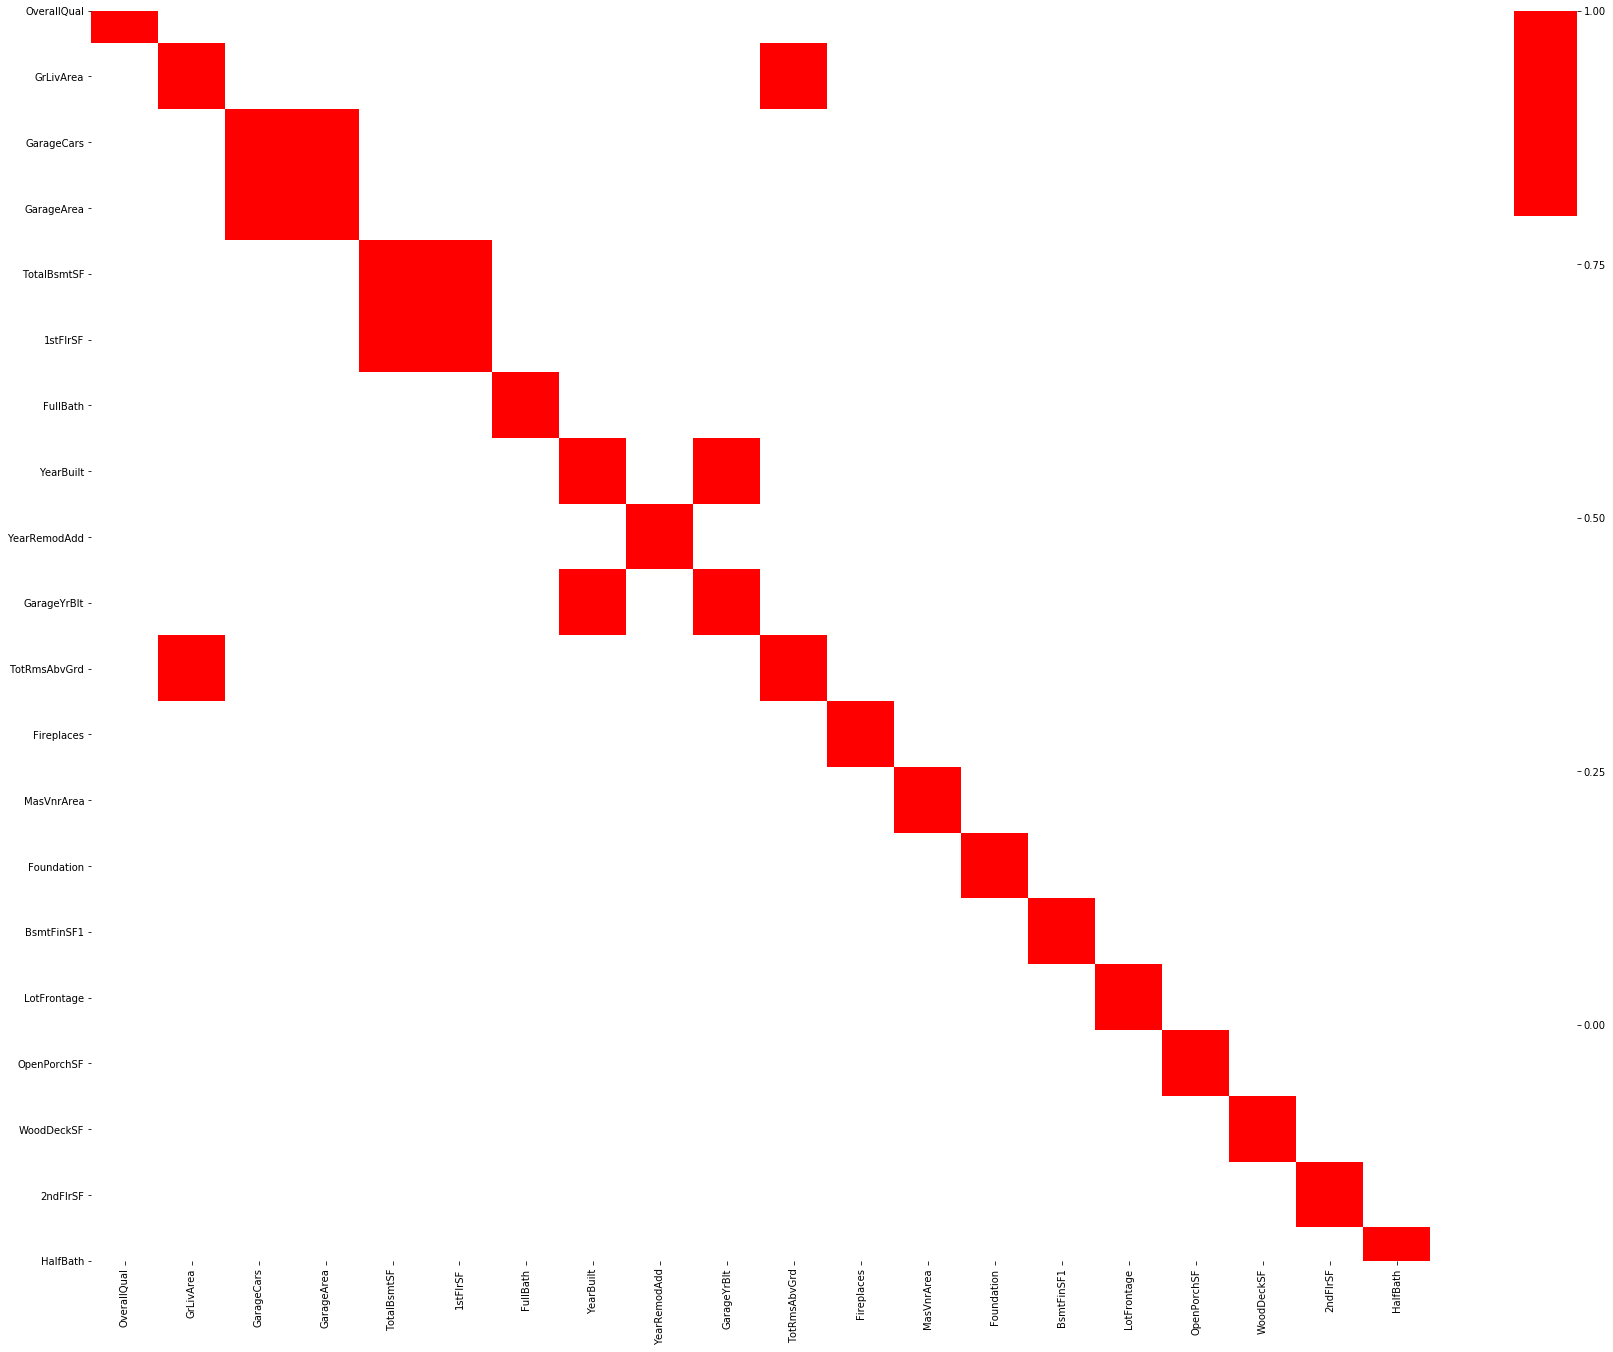

In [611]:
from matplotlib import cm
from collections import OrderedDict

fig, ax = plt.subplots(figsize=(30, 23))
cmaps = OrderedDict()
colormap = cmaps['Sequential'] = ['white', 'red']
sns.heatmap(data[best_corr].corr(), cmap=colormap, center=0.8, ax=ax)

In [612]:
union_fe = list(set(list(feat_importances.nlargest(60).index) + list(featureScores.nlargest(25,'Score')['Specs']) + list(best_corr)))
len(union_fe)

65

Некоторые потенциально важные признаки ухудшали качество модели, от каких избавляться, а от какких нет - было выяснено опытным путем

In [613]:
#union_fe.remove('class_3')
#union_fe.remove('class_6')
#union_fe.remove('class_12')

## Нейронная сеть

In [614]:
#data_for_linear = data.copy()
#target_for_linear = data_target.copy()

In [615]:
#from sklearn.preprocessing import StandardScaler
#
#scaler = StandardScaler()
#data_for_linear = pd.DataFrame(scaler.fit_transform(data_for_linear), columns=data.columns)
#
#target_for_linear = np.log(1 + target_for_linear)

In [616]:
#import torch
#from torch import nn
#
#net = nn.Sequential()
#net.add_module('first', nn.Linear(scaled_data.shape[1], 10))
#net.add_module('second', nn.Linear(10, 100))
#net.add_module('thred', nn.Linear(100, 10))
#net.add_module('forth', nn.Linear(10, 1))
#
#
#opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [617]:
#train_data, test_data, train_labels, test_labels = train_test_split(scaled_data,
#                                                                    scaled_target_sqrt, random_state=42, test_size=0.2)

In [618]:
#torch.tensor(train_labels.values[0], dtype=torch.float32)

In [619]:
#history = []
#
#for i in range(10_000):
#    
#    ix = np.random.randint(0, len(train_data), int(len(train_data) * 0.8))
#    x_batch = torch.tensor(train_data.values[ix], dtype=torch.float32)
#    y_batch = torch.tensor(train_labels.values[ix], dtype=torch.float32)
#    
#    predicted = net(x_batch)[0]  
#    loss = torch.mean(abs(y_batch - predicted ))
#    loss.backward()
#    opt.step()
#    opt.zero_grad()
#    
#    history.append(loss.data.numpy())
#    
#    if i % 10 == 0:
#        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

In [620]:
#pred = net(torch.tensor(test_data.values, dtype=torch.float32))

In [621]:
#prediction = np.zeros(len(pred))
#
#for i in range(len(pred)):
#    prediction[i] = pred[i] ** 2
#
#from sklearn.metrics import mean_absolute_error as mae
#mae(test_labels ** 2, prediction)
#
#
## Нейросеть показала ужасный результат

## Ridge

In [622]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

scaled_target_log = np.log(data_target)
scaled_target_sqrt = np.sqrt(data_target)

In [623]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.4, random_state=42, normalize=False, tol=1e-05)

#ridge.fit(train_lasso_data, train_lasso_labels)
#prediction_lasso = ridge.predict(test_lasso_data)
#
#mae(test_lasso_labels, prediction_lasso)

In [624]:
%%time
from sklearn.model_selection import KFold, cross_val_score

split = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(ridge, X=scaled_data, 
                            y=scaled_target_sqrt, scoring='neg_mean_absolute_error', cv=50)

cv_scores.mean()

Wall time: 711 ms


-20.243140223566524

In [625]:
#mae_sqrt = []
#
#for i in range(300):
#    
#    ix = np.random.randint(100_000)
#    
#    train_lasso_data, test_lasso_data, train_lasso_labels, test_lasso_labels = train_test_split(scaled_data, 
#                                                 scaled_target_sqrt, shuffle=True, test_size=0.2, random_state=ix)
#    
#    ridge.fit(train_lasso_data, train_lasso_labels)
#    
#    prediction = ridge.predict(test_lasso_data)
#    
#    mae_sqrt.append(mae(prediction ** 2, test_lasso_labels ** 2)) # mae = 17844.318    
#np.array(mae_sqrt).mean()

In [626]:
#train_lasso_data, test_lasso_data, train_lasso_labels, test_lasso_labels = train_test_split(data[union_fe], 
#                                             data_target, shuffle=True, test_size=0.25, random_state = 42)
#
#
#ridge = Ridge(normalize=True, alpha=0.4)
#
#param_grid = {
#                'tol' : np.linspace(0.00001, 0.001, 10),
#           #     'alpha' : np.linspace(0.1, 1, 10),
#           #         'normalize' : [True, False]
#
#}
#grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, error_score='mae', cv=2)
#grid_search.fit(X=train_lasso_data, y=train_lasso_labels) 
#
#grid_search.best_estimator_

In [627]:
#ridge = Ridge(alpha=0.4, random_state=42, normalize=True, tol=1e-05)
#
#mae(test_lasso_labels, prediction_lasso)

In [628]:
train_ridge_data, test_ridge_data, train_ridge_labels, test_ridge_labels = train_test_split(data[union_fe], 
                                             data_target, shuffle=True, test_size=0.25, random_state = 42)

ridge.fit(train_ridge_data, train_ridge_labels)

prediction_ridge = ridge.predict(data[union_fe])

In [629]:
data['prediction_ridge'] = prediction_ridge

## Lasso

In [630]:
#train_lasso_data, test_lasso_data, train_lasso_labels, test_lasso_labels = train_test_split(data[union_fe], 
#                                             data_target, shuffle=True, test_size=0.5, random_state = 42)
#
#                                                                                            
#from sklearn.linear_model import LassoCV
#
#lasso = LassoCV(n_jobs=-1)
#
#param_grid = {
#                'eps' : [0.001, 0.01, 0.0001],
#                'n_alphas' : [100, 50, 200],
#                'normalize' : [True, False]
#}
#grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, error_score='mae', cv=2)
#grid_search.fit(X=train_lasso_data, y=train_lasso_labels) 
#
#grid_search.best_estimator_

In [631]:
#lasso = LassoCV(eps=0.001, n_alphas=50, n_jobs=-1, normalize=True, random_state=42)
#
#lasso.fit(train_lasso_data, train_lasso_labels)
#prediction_lasso = lasso.predict(test_lasso_data[union_fe])
#
#mae(test_lasso_labels, prediction_lasso)

In [632]:
#from sklearn import svm 
#model = svm.SVR(kernel='rbf')
#model.fit(train_lasso_data, train_lasso_labels)
#
#prediction_svm = model.predict(test_lasso_data)
#mae(np.exp(test_lasso_labels) - 1, prediction_svm)

In [633]:
#lasso.fit(data, data_target)

#prediction_lasso = lasso.predict(data[union_fe])

In [634]:
#data['prediction_lasso'] = prediction_lasso

## XGBoost: 

In [635]:
union_fe.append('prediction_ridge')

In [636]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,YrSold,SaleType,SaleCondition,is_Garage,is_Bsmt,class_3,class_6,class_9,class_12,prediction_ridge
0,60,3,65.0,8450,1,1,3,3,0,4,...,2008,8,4,0,0,0,3,8,8,215753.659227
1,20,3,80.0,9600,1,1,3,3,0,2,...,2007,8,4,0,0,0,1,4,4,196197.907562
2,60,3,68.0,11250,1,1,0,3,0,4,...,2008,8,4,0,0,1,5,5,11,216357.016703
3,70,3,60.0,9550,1,1,0,3,0,0,...,2006,8,0,0,0,0,3,2,5,163569.405162
4,60,3,84.0,14260,1,1,0,3,0,2,...,2008,8,4,0,0,1,0,3,3,280973.173784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,1,3,3,0,4,...,2007,8,4,0,0,0,3,8,8,167623.587451
1456,20,3,85.0,13175,1,1,3,3,0,4,...,2010,8,4,0,0,1,0,3,2,227286.556201
1457,70,3,66.0,9042,1,1,3,3,0,4,...,2010,8,4,0,0,0,4,1,1,251820.539068
1458,20,3,68.0,9717,1,1,3,3,0,4,...,2010,8,4,0,0,0,1,4,4,135915.633422


In [637]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
#
#xgb_reg = XGBRegressor(n_jobs=-1, subsample=0.9)
#
#param_grid = {
#                'learning_rate' : [0.01, 0.007, 0.004],
#                'max_depth' : [2, 3, 4],
#                'n_estimators' : [1000, 1500, 2000]
#             }
#grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, error_score='mae', cv=2)
#grid_search.fit(X=train_xgb_data, y=train_xgb_labels) 

In [638]:
#print(grid_search.best_estimator_)

#XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#             colsample_bynode=1, colsample_bytree=1, gamma=0,
#             importance_type='gain', learning_rate=0.01, max_delta_step=0,
#             max_depth=4, min_child_weight=1, missing=None, n_estimators=1500,
#             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
#             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#             silent=None, subsample=1, verbosity=1)

In [639]:
#xgb_best_reg = XGBRegressor(learning_rate=0.065555555, n_estimators=2000, max_depth = 2, 
#                    random_state=42, subsample=0.9)
##xgb_best_reg = XGBRegressor(learning_rate=0.01, n_estimators=1000, max_depth=4,
#                            random_state=42, n_jobs=-1, subsample=0.9)
#xgb_best_reg = XGBRegressor(learning_rate=0.035, n_estimators=2000, max_depth = 2,
#                            random_state=42, n_jobs=-1, subsample=0.85)
#xgb_best_reg = XGBRegressor(learning_rate=0.01, n_estimators=2000, max_depth = 3,
#                            random_state=42, n_jobs=-1, subsample=0.8)


xgb_reg = XGBRegressor(learning_rate=0.02, n_estimators=5000, max_depth = 2, random_state=42)

In [640]:
%%time

split = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(xgb_best_reg, X=data[union_fe],
                            y=data_target, scoring='neg_mean_absolute_error', cv=10)

cv_scores.mean()
# без union_fe mae = 13_700 
# c 65 union_fe и prediction_lasso mae = 13_640
# c 71 union_fe  и prediction_lasso mae = 13_950 
# c 61 union_fe  и prediction_lasso mae = 13_970 

[14:51:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:29] WARNI

-14032.138984628928

In [565]:
#for i in range(10):
#
#    train_xgb_data, test_xgb_data, train_xgb_labels, test_xgb_labels = train_test_split(data[union_fe], data_target, 
#                                                shuffle=True, test_size=0.25 , random_state = i*42)
#    xgb_reg = XGBRegressor(n_jobs=-2)
#    param_grid = {
#                    'learning_rate' : [0.01, 0.1, 0.001],
#                    'max_depth' : [2, 3],
#                    'n_estimators' : [800, 1500]
#                 }
#    grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, error_score='mae', cv=2)
#    grid_search.fit(X=train_xgb_data, y=train_xgb_labels) 
#    
#    print('best xgb {}'.format(i), grid_search.best_estimator_)
#    
#    xgb_best_reg = grid_search.best_estimator_
#    xgb_best_reg.fit(X=train_xgb_data, y=train_xgb_labels)
#    prediction_xgb = xgb_best_reg.predict(test_xgb_data)
#    
#    print(met.mean_absolute_error(test_xgb_labels, prediction_xgb))

In [410]:
%%time

xgb_best_reg = XGBRegressor(learning_rate=0.035, n_estimators=2000, max_depth = 3,
                            random_state=42, n_jobs=-1, subsample=0.8)

xgb_best_reg.fit(X=train_xgb_data, y=train_xgb_labels)

[11:34:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 8.58 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.035, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [411]:
prediction_xgb = xgb_best_reg.predict(test_xgb_data)
met.mean_absolute_error(test_xgb_labels, prediction_xgb)

14501.731347484621

In [168]:
prediction_xgb = xgb_best_reg.predict(data[union_fe])

In [172]:
len(prediction_xgb), len(prediction_ridge)

(1422, 1422)

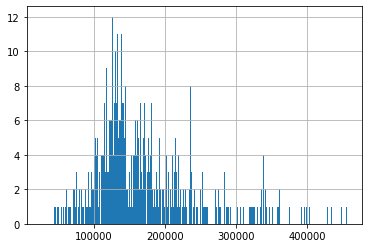

In [419]:
pd.Series(prediction_33).hist(bins=1000)

In [422]:
print(prediction_33.mean())
print(data_target.mean(    ))

174381.42
177588.5393811533


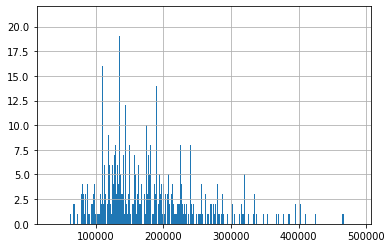

In [421]:
data_target.hist(bins=1000)

## Stacking

In [173]:
stack = pd.DataFrame(np.hstack((prediction_xgb.reshape(-1, 1), prediction_ridge.reshape(-1, 1))), 
                     columns=['prediction_xgb', 'prediction_ridge'])
stack

,prediction_xgb,prediction_ridge
0,211737.703125,214571.703652
1,180779.890625,189753.628194
2,223392.484375,217576.029030
3,147209.296875,163217.616178
4,260405.171875,276827.992754
...,...,...
1417,176699.843750,175393.598570
1418,201130.484375,211889.493487
1419,262431.468750,241550.578442
1420,140159.687500,138916.637133


In [174]:
train_xgb_data, test_xgb_data, train_xgb_labels, test_xgb_labels = train_test_split(stack, data_target, 
                                                    shuffle=True, test_size=0.2 , random_state = 42)

In [175]:
xgb_reg = XGBRegressor(n_jobs=-1, subsample=0.9)

param_grid = {
                'learning_rate' : [0.01, 0.007, 0.004],
                'max_depth' : [2, 3, 4],
                'n_estimators' : [1000, 1500, 2000]
             }
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, error_score='mae', cv=2)
grid_search.fit(X=train_xgb_data, y=train_xgb_labels) 

[17:13:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:54] WARNI

KeyboardInterrupt: 

In [ ]:
grid_search.best_estimator_

In [177]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_xgb_data, train_xgb_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [178]:
prediction_xgb = reg.predict(test_xgb_data)
met.mean_absolute_error(test_xgb_labels, prediction_xgb)

13684.360636670519

## Проверяем как хорошо модель работает на тех же тренировочных данных 

In [ ]:
xgb_best_reg.fit(X=data[union_fe], y=data_target)

In [ ]:
prediction_xgb = xgb_best_reg.predict(data[union_fe])
met.mean_absolute_error(data_target, prediction_xgb)

In [ ]:
#bad_index_in_train_data = []
#for i in range(data_target.shape[0]):
#    if abs(data_target[i] - prediction_xgb[i]) > 25_000:
#        bad_index_in_train_data.append(i)
#bad_index_in_train_data

In [ ]:
#bad_index_in_train_data = [4, 13, 131, 238, 244, 261, 462, 559, 
#        600, 632, 681, 688, 714, 744, 822, 864, 970, 1065, 1324, 1359]

In [ ]:
#data_without_bad_index = data.copy()
#data_target_without_bad_index = data_target.copy()
#
#data_without_bad_index = data_without_bad_index.drop(index=bad_index_in_train_data)
#data_target_without_bad_index = data_target_without_bad_index.drop(index=bad_index_in_train_data)

In [ ]:
#bad_index_in_test_data = []
#for i in range(len(bad_index_in_train_data)):
#    for j in range(test_data.shape[0]):
#        cor = np.corrcoef(data.values[data.index==bad_index_in_train_data[i]], 
#                      test_data.values[test_data.index==j])
#        if cor[0][1] > 0.9995:
#            bad_index_in_train_data.append(bad_index_in_train_data[i])
#            bad_index_in_test_data.append(j)

In [ ]:
#bad_index_in_train_data = bad_index_in_train_data[20:]
#bad_index_in_train_data

In [ ]:
#bad_index_in_train_data = pd.DataFrame(bad_index_in_train_data)
#bad_index_in_test_data = pd.DataFrame(bad_index_in_test_data)

In [ ]:
#df_to_change = pd.DataFrame(data = np.hstack((bad_index_in_train_data, bad_index_in_test_data)),
#             columns = ['bad_index_in_train_data', 'bad_index_in_test_data'])

In [ ]:
#xgb_best_reg.fit(X=data_without_bad_index[union_fe], y=data_target_without_bad_index)

In [ ]:
#prediction_xgb = xgb_best_reg.predict(data_without_bad_index[union_fe])
#met.mean_absolute_error(data_target_without_bad_index, prediction_xgb)

In [ ]:
#bad_prediction = [4, 13, 131, 238, 244, 261, 462, 559, 
#        600, 632, 681, 688, 714, 744, 822, 864, 970, 1065, 1324, 1359]
# индексы данных, ошибка на которых больше 25_000 при обучении без мусора на union_fe

## Работаем с тестовыми данными : 

In [454]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
test_data_ID = test_data['Id']
test_data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [455]:
test_data.drop(labels='Id', axis=1, inplace=True)

In [456]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non

## Заполнение пустых значений

In [457]:
test_data.Alley = test_data.Alley.fillna('NA')

test_data["LotFrontage"] = test_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

test_data.MasVnrArea = test_data.MasVnrArea.fillna(0)

In [458]:
print(len(test_data['GarageCars'][test_data['GarageCars'] == 0]), 'Гараж не имеет место для машины ==> их нет')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    test_data[col].fillna('No_Garage', inplace=True)

test_data['is_Garage'] = (test_data['GarageCars'] == 0)*1 # Признак есть ли гараж

76 Гараж не имеет место для машины ==> их нет


In [459]:
print(len(test_data['TotalBsmtSF'][test_data['TotalBsmtSF'] == 0]), 'Домов не имеют подвала')

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    test_data[col].fillna('No_Bstm', inplace=True)

test_data['is_Bsmt'] = (test_data['TotalBsmtSF'] == 0)*1 # Признак есть ли подвал

41 Домов не имеют подвала


In [460]:
test_data["GarageYrBlt"] = test_data.groupby("YearBuilt")["GarageYrBlt"].transform(
    lambda x: x.fillna(x.median()))

test_data["GarageYrBlt"] = test_data["GarageYrBlt"].fillna(data["GarageYrBlt"].median())

In [461]:
for col in cat_features:
    test_data[col].fillna('No{}'.format(col), inplace=True)

In [462]:
a = test_data['MSZoning'].describe().top
a

'RL'

In [463]:
for col in num_features:
    fill = test_data[col].median()
    test_data[col].fillna(fill, inplace=True)

In [464]:
for col in cat_features:
    fill = test_data[col].describe().top
    test_data[col].fillna(fill, inplace=True)

In [465]:
# 1458 значений 2-х призl,mнаков не пустые и не одного значения в них не "NA", следовательно заполняем не нулями

#sns.countplot(test_data.BsmtQual)

In [466]:
#test_data["BsmtQual"][test_data.BsmtFinType1 == 'GLQ'] = test_data[test_data.BsmtFinType1 == 'GLQ']["BsmtQual"].fillna('Gd')
#test_data["BsmtQual"][test_data.BsmtFinType1 == 'Unf'] = test_data[test_data.BsmtFinType1 == 'Unf']["BsmtQual"].fillna('Gd')
#test_data["BsmtQual"] = test_data["BsmtQual"].fillna('TA')

In [467]:
#test_data["Fireplaces"] = test_data["Fireplaces"].fillna('NA')

In [468]:
#test_data.PoolArea = test_data.PoolArea.fillna('NA')

In [469]:
##test_data[cat_features] = test_data[cat_features].fillna('NA')
#imp = SimpleImputer(strategy='most_frequent')
#test_data = pd.DataFrame(imp.fit_transform(test_data), columns=data.columns)
##test_data[cat_features]

In [470]:
cat_features = test_data.select_dtypes(include='object').columns

In [472]:
for label in cat_features:
    test_data[label] = encoder.fit_transform(test_data[label])
#test_data[cat_features]

In [473]:
#for label in test_data[num_features].columns:
#    
#    test_data[label] = test_data[label].fillna(test_data[label].median())

## TSNE

In [475]:
%%time
tsne_test_data = tsne.fit_transform(test_data)

Wall time: 21.3 s


In [476]:
for i in range(1, 5):
    clust = AgglomerativeClustering(n_clusters=3*i)
    new_class = clust.fit_predict(tsne_test_data)
    test_data['class_{}'.format(3*i)] = new_class

## Ridge

In [478]:
#union_fe.remove('prediction_ridge')

In [479]:
prediction_ridge = ridge.predict(test_data)

test_data['prediction_ridge'] = prediction_ridge

## Lasso

In [ ]:
prediction_lasso = lasso.predict(test_data[union_fe])

test_data['prediction_lasso'] = prediction_lasso

In [ ]:
union_fe.append('prediction_lasso')

In [ ]:
#%%time
#mds_test_data = mds_test.fit_transform(test_data)

In [ ]:
#plt.figure(figsize = (30, 30))
#plt.scatter(mds_test_data[:, 0], mds_test_data[:, 1], s=40)

In [ ]:
#rubbish_test_index = []
#for i in range(len(mds_test_data)):
#   if (abs(mds_test_data[:, 1][i]) > 10_000) or (abs(mds_test_data[:, 0][i]) > 20_000):
#        rubbish_test_index.append(i)
#print(rubbish_test_index)
#len(rubbish_test_index)

In [ ]:
#rubbish_test_index = [1, 487, 728, 790, 803, 804, 1089, 1139, 1147, 1157, 1336, 1440, 1444]

In [ ]:
#mds_test_data_without_rubbish = mds_test_data.copy()
#plt.figure(figsize = (30, 30))
#for i in range(len(mds_test_data)):
#    if (abs(mds_test_data_without_rubbish[:, 1][i]) < 10_000) and (abs(mds_test_data_without_rubbish[:, 0][i]) < 20_000):
#        plt.scatter(mds_test_data_without_rubbish[i:i+1, 0], mds_test_data_without_rubbish[i:i+1, 1], s=40)

In [ ]:
#rubbish_test_data = pd.DataFrame(test_data, index = rubbish_test_index)

In [ ]:
#[249, 313, 335, 451, 706]

In [ ]:
#kmeans = KMeans(n_clusters=3, random_state=42)
#new_class = kmeans.fit_predict(tsne_test_data)
# разделяет хуже, результат тоже хуже

In [480]:
test_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,YrSold,SaleType,SaleCondition,is_Garage,is_Bsmt,class_3,class_6,class_9,class_12,prediction_ridge
0,20,3,80.0,11622,1,1,3,3,0,4,...,2010,9,4,0,0,0,1,8,3,59844.662194
1,20,4,81.0,14267,1,1,0,3,0,0,...,2010,9,4,0,0,0,1,8,3,73269.778187
2,60,4,74.0,13830,1,1,0,3,0,4,...,2010,9,4,0,0,0,4,0,9,73616.952406
3,60,4,78.0,9978,1,1,0,3,0,4,...,2010,9,4,0,0,0,4,0,8,64686.591047
4,120,4,43.0,5005,1,1,0,1,0,4,...,2010,9,4,0,0,1,0,6,6,49368.426331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,5,21.0,1936,1,1,3,3,0,4,...,2006,9,4,1,0,1,0,5,0,33623.020751
1455,160,5,21.0,1894,1,1,3,3,0,4,...,2006,9,0,0,0,1,0,5,0,35132.091427
1456,20,4,160.0,20000,1,1,3,3,0,4,...,2006,9,0,0,0,2,2,7,7,85693.724433
1457,85,4,62.0,10441,1,1,3,3,0,4,...,2006,9,4,1,0,0,1,8,3,54389.887116


In [ ]:
xgb_best_reg.fit(X=data[union_fe], y=data_target)

In [ ]:
prediction_33 = xgb_best_reg.predict(test_data[union_fe])
prediction_33.shape

In [507]:
output = pd.DataFrame({'Id': test_data_ID,
                       'SalePrice': prediction_33})
output.to_csv('submission33.csv', index=False)
# mae = 14600

In [508]:
# Константные предсказания:
# 170_000 - 59862.13580
# 177_588 - 61004.71854
# 182_000 - 61916.53635
# 160_000 - 59344.33058 best +
# 155_000 - 59541.44993
# 165_000 - 59489.32373
# 162_500 - 59387.12894
# 161_000 - 59357.36213
# 159_000 - 59355.03017
# 159_800 - 59345.97668
# 160_200 - 59346.25102

# Следовательно среднее значение таргета в тестовом датасете 160_000

In [534]:
sub_best = pd.read_csv('submission25.csv')

average = sub_best['SalePrice'].mean()

#diviation = sub_best['SalePrice'].mean() - 160_000
#print('Разность среднего в лучшем предсказании и оптимального среднего, найденного методом перебора: ', diviation)
#
#sub_best['SalePrice'] = sub_best['SalePrice'] - diviation/10
#sub_best

# Не работает, лучший результат не улучшается, попробую со средним = 179602.4548

In [547]:
#sub_best['SalePrice'].mean(), sub_best['SalePrice'].std()

In [548]:
#sub_best['SalePrice'].hist(bins=1000)

In [549]:
#data_target.hist(bins=1000)

In [530]:
#sub_best.to_csv('best_sub-2_000.csv', index=False)

In [ ]:
print(prediction_33)